### Controller Demo

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [6]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Load chromatogram data exported from R

In [7]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
chromatograms = ChromatogramCreator(xcms_output)

DEBUG:Chromatograms:Loading 0 chromatograms
../codes\VMSfunctions\Common.py:55: RuntimeWarning:

divide by zero encountered in double_scalars

DEBUG:Chromatograms:Loading 5000 chromatograms
DEBUG:Chromatograms:Loading 10000 chromatograms
DEBUG:Chromatograms:Loading 15000 chromatograms
DEBUG:Chromatograms:Loading 20000 chromatograms
DEBUG:Chromatograms:Loading 25000 chromatograms
DEBUG:Chromatograms:Loading 30000 chromatograms
DEBUG:Chromatograms:Loading 35000 chromatograms
DEBUG:Chromatograms:Loading 40000 chromatograms
DEBUG:Chromatograms:Loading 45000 chromatograms


### Generate some chemicals

In [8]:
hmdb = load_obj('../models/hmdb_compounds.p')

In [9]:
chemicals = ChemicalCreator(ps, chromatograms)

In [10]:
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
sampled_chemicals = chemicals.sample(min_rt, max_rt, min_ms1_intensity, 1000, 2, 'Unknown', 'Empirical', None, False, hmdb)

DEBUG:Chemicals:1000 ms1 peaks to be created.
DEBUG:Chemicals:i = 10 Total = 11
DEBUG:Chemicals:i = 20 Total = 25
DEBUG:Chemicals:i = 20 Total = 26
DEBUG:Chemicals:i = 30 Total = 42
DEBUG:Chemicals:i = 40 Total = 57
DEBUG:Chemicals:i = 50 Total = 71
DEBUG:Chemicals:i = 60 Total = 85
DEBUG:Chemicals:i = 70 Total = 98
DEBUG:Chemicals:i = 80 Total = 111
DEBUG:Chemicals:i = 90 Total = 126
DEBUG:Chemicals:i = 90 Total = 127
DEBUG:Chemicals:i = 100 Total = 141
DEBUG:Chemicals:i = 110 Total = 155
DEBUG:Chemicals:i = 120 Total = 171
DEBUG:Chemicals:i = 130 Total = 183
DEBUG:Chemicals:i = 140 Total = 193
DEBUG:Chemicals:i = 150 Total = 206
DEBUG:Chemicals:i = 160 Total = 216
DEBUG:Chemicals:i = 170 Total = 227
DEBUG:Chemicals:i = 170 Total = 228
DEBUG:Chemicals:i = 180 Total = 240
DEBUG:Chemicals:i = 180 Total = 241
DEBUG:Chemicals:i = 180 Total = 242
DEBUG:Chemicals:i = 190 Total = 254
DEBUG:Chemicals:i = 200 Total = 268
DEBUG:Chemicals:i = 210 Total = 279
DEBUG:Chemicals:i = 210 Total = 280
D

UnknownChemical mz=355.8167 rt=1001.79 max_intensity=302388.48
[210986.0625   223816.5625   176179.15625  262266.5      257301.21875
 253858.8125   302396.03125  263967.71875  246354.921875 226727.53125 ]


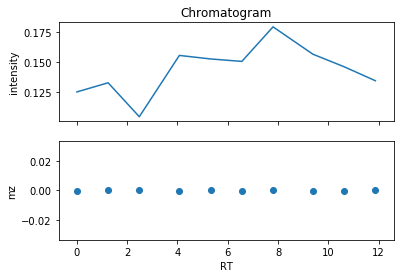

UnknownChemical mz=648.4721 rt=656.18 max_intensity=443917.29
[ 59356.78515625  71432.4453125  203788.875      189169.859375
 100983.71875    292754.28125    344994.4375     443891.78125
 329622.6875     269967.21875    322332.0625     220287.796875
 179505.359375  ]


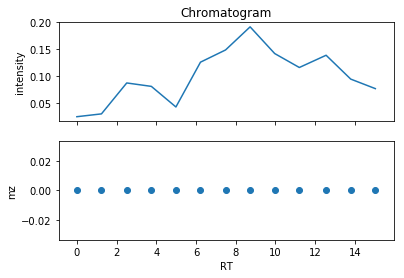

UnknownChemical mz=389.1789 rt=494.37 max_intensity=534796.70
[ 86679.0859375  132736.625       81848.9296875  250470.390625
 408498.3125     534821.625      373221.8125     409531.375
 358754.15625    298362.40625    229243.984375   108193.8046875
 121678.6875      62146.63671875]


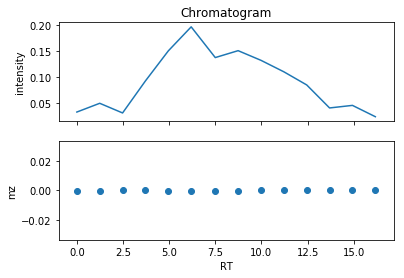

UnknownChemical mz=210.7797 rt=788.50 max_intensity=1766828.74
[1573438.375  1391427.5    1766692.125  1404630.375  1559220.25
 1332505.875  1273351.5     994578.9375  916954.9375  848796.1875]


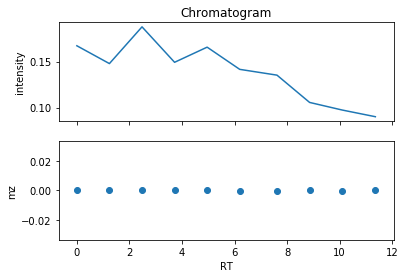

UnknownChemical mz=124.9689 rt=827.83 max_intensity=771586.63
[275478.625   265164.8125  358869.96875 381634.34375 504088.09375
 454207.5     516830.5625  771710.8125  666829.5625  502794.1875
 353520.4375  224945.      251271.90625]


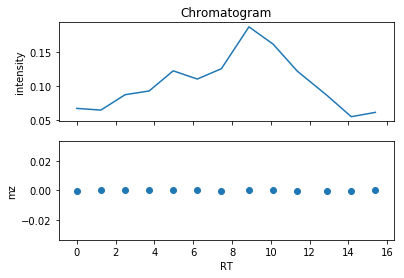

UnknownChemical mz=179.3934 rt=1244.28 max_intensity=6183373.87
[4752400.5 4646292.  5076158.  5505802.5 5443421.  5513127.  5377093.
 6182547.5 5513318.  5291223.  5075957.5 5480899.5]


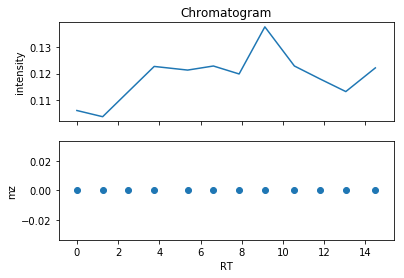

UnknownChemical mz=149.7399 rt=999.65 max_intensity=2435700.83
[ 461315.1875    525656.5625   1068176.       1515637.75
 2435752.       2048860.125    1295561.375    1053631.875
  675100.5       235913.453125]


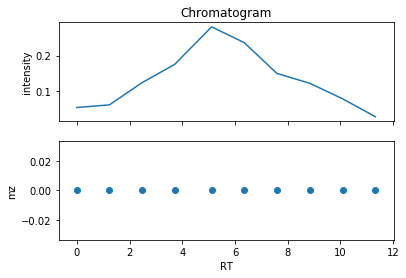

UnknownChemical mz=293.1761 rt=1052.09 max_intensity=1157222.46
[ 461296.34375   501860.28125   548630.8125    472724.8125
  715425.9375    859691.75      822575.       1009950.8125
  922684.       1073077.625    1059011.75      990278.75
 1157529.375     949109.9375   1128571.375     769940.25
 1012467.625     732922.25      842973.4375    734682.0625
  659512.6875    643451.3125    404661.6875    299193.9375
  211343.671875]


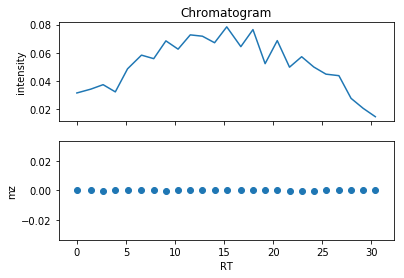

UnknownChemical mz=114.4745 rt=1106.37 max_intensity=1870868.26
[1681717.5   1692327.625 1871185.    1814832.625]


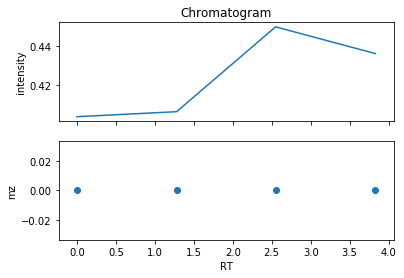

UnknownChemical mz=183.0009 rt=624.94 max_intensity=7165733.24
[ 175667.4375  811336.5    2185430.     4331555.     5785692.
 7168866.     5629088.5    4459849.     3954137.25   3263947.
 2425890.75   1983412.5    1372343.125   829834.75  ]


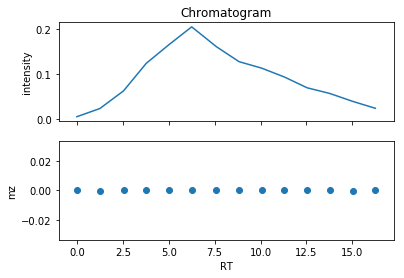

In [11]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in sampled_chemicals[0:10]:
    print(chem)
    print(chem.chromatogram.raw_intensities)
    plot_chromatogram(chem.chromatogram)

### Set up a simple MS1 controller

In [12]:
max_rt = 185

In [13]:
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals, density=ps.density_estimator)
controller = SimpleMs1Controller(mass_spec)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(max_rt)

INFO:SimpleMs1Controller:Acquisition open
INFO:SimpleMs1Controller:Received Scan 1404 num_peaks=1 rt=181.52 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1405 num_peaks=1 rt=181.60 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1406 num_peaks=1 rt=181.71 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1407 num_peaks=1 rt=181.79 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1408 num_peaks=1 rt=181.86 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1409 num_peaks=1 rt=181.93 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1410 num_peaks=1 rt=182.01 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1411 num_peaks=1 rt=182.27 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1412 num_peaks=1 rt=182.36 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1413 num_peaks=1 rt=182.43 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1414 num_peaks=1 rt=182.50 ms_level=1
INFO:SimpleMs1Controller:Received Scan 1415 num_peaks=1 rt=182.63 ms_level=1
INFO:SimpleMs1Controller:Received 

### Set up a Top-N controller

In [14]:
max_rt = 200                    # the maximum retention time of scans to generate
N = 5                           # top-5 DDA fragmentation
mz_tol = 5                      # the mz isolation window around a selected precursor ion
rt_tol = 15                     # the rt window around a selected precursor ion to prevent it from fragmented multiple times
min_ms2_intensity = 5000        # the minimum ms2 peak intensity

In [15]:
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals, density=ps.density_estimator)
controller = TopNController(mass_spec, N, mz_tol, rt_tol, min_ms2_intensity=min_ms2_intensity)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(max_rt)

INFO:TopNController:Acquisition open
INFO:TopNController:Received Scan 1397 num_peaks=1 rt=181.43 ms_level=1
INFO:TopNController:Received Scan 1398 num_peaks=1 rt=181.50 ms_level=2
INFO:TopNController:Received Scan 1399 num_peaks=1 rt=181.63 ms_level=1
INFO:TopNController:Received Scan 1400 num_peaks=1 rt=181.70 ms_level=1
INFO:TopNController:Received Scan 1401 num_peaks=1 rt=181.77 ms_level=1
INFO:TopNController:Received Scan 1402 num_peaks=1 rt=181.95 ms_level=1
INFO:TopNController:Received Scan 1403 num_peaks=1 rt=182.10 ms_level=1
INFO:TopNController:Received Scan 1404 num_peaks=1 rt=182.50 ms_level=1
INFO:TopNController:Received Scan 1405 num_peaks=1 rt=182.59 ms_level=1
INFO:TopNController:Received Scan 1406 num_peaks=1 rt=182.66 ms_level=1
INFO:TopNController:Received Scan 1407 num_peaks=1 rt=182.73 ms_level=1
INFO:TopNController:Received Scan 1408 num_peaks=1 rt=182.80 ms_level=1
INFO:TopNController:Received Scan 1409 num_peaks=1 rt=182.88 ms_level=1
INFO:TopNController:Receive

INFO:TopNController:Received Scan 1511 num_peaks=8 rt=196.09 ms_level=1
INFO:TopNController:Received Scan 1512 num_peaks=1 rt=196.20 ms_level=2
INFO:TopNController:Received Scan 1513 num_peaks=8 rt=196.47 ms_level=1
INFO:TopNController:Received Scan 1514 num_peaks=1 rt=196.63 ms_level=2
INFO:TopNController:Received Scan 1515 num_peaks=1 rt=196.79 ms_level=2
INFO:TopNController:Received Scan 1516 num_peaks=9 rt=196.90 ms_level=1
INFO:TopNController:Received Scan 1517 num_peaks=9 rt=197.03 ms_level=1
INFO:TopNController:Received Scan 1518 num_peaks=9 rt=197.10 ms_level=1
INFO:TopNController:Received Scan 1519 num_peaks=9 rt=197.17 ms_level=1
INFO:TopNController:Received Scan 1520 num_peaks=9 rt=197.25 ms_level=1
INFO:TopNController:Received Scan 1521 num_peaks=9 rt=197.34 ms_level=1
INFO:TopNController:Received Scan 1522 num_peaks=9 rt=197.41 ms_level=1
INFO:TopNController:Received Scan 1523 num_peaks=9 rt=197.49 ms_level=1
INFO:TopNController:Received Scan 1524 num_peaks=1 rt=197.67 ms_

In [16]:
controller.write_mzML('my_analysis', '../models/out.mzML')

### Set up a DIA controller

In [17]:
max_rt = 200
dia_design = "basic"
window_type = "even"
kaufmann_design = None
extra_bins = 0
num_windows = 10

In [18]:
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals, density=ps.density_estimator)
controller = TreeController(mass_spec, dia_design, window_type, kaufmann_design, extra_bins, num_windows)

set_log_level_info()
controller.make_plot = False

# set_log_level_debug()
# controller.make_plot = True

controller.run(max_rt)

INFO:TreeController:Acquisition open
INFO:TreeController:Received MS1 scan Scan 1477 num_peaks=1 rt=181.41 ms_level=1
INFO:TreeController:Received MS2 scan Scan 1481 num_peaks=1 rt=182.09 ms_level=2
INFO:TreeController:Received MS1 scan Scan 1488 num_peaks=1 rt=183.15 ms_level=1
INFO:TreeController:Received MS2 scan Scan 1490 num_peaks=1 rt=183.35 ms_level=2
INFO:TreeController:Received MS2 scan Scan 1492 num_peaks=1 rt=183.77 ms_level=2
INFO:TreeController:Received MS1 scan Scan 1499 num_peaks=3 rt=185.07 ms_level=1
INFO:TreeController:Received MS2 scan Scan 1501 num_peaks=1 rt=185.56 ms_level=2
INFO:TreeController:Received MS2 scan Scan 1503 num_peaks=1 rt=185.85 ms_level=2
INFO:TreeController:Received MS2 scan Scan 1504 num_peaks=1 rt=185.99 ms_level=2
INFO:TreeController:Received MS1 scan Scan 1510 num_peaks=4 rt=187.03 ms_level=1
INFO:TreeController:Received MS2 scan Scan 1512 num_peaks=1 rt=187.32 ms_level=2
INFO:TreeController:Received MS2 scan Scan 1513 num_peaks=2 rt=187.46 ms

In [19]:
controller.write_mzML('my_analysis', '../models/out.mzML')